In [ ]:
!pip install -e "git+https://github.com/bcollazo/catanatron.git@master#egg=catanatron&subdirectory=catanatron_core"
!pip install -e "git+https://github.com/bcollazo/catanatron.git@master#egg=catanatron_gym&subdirectory=catanatron_gym"
!pip install -r "https://raw.githubusercontent.com/bcollazo/catanatron/master/dev-requirements.txt"
!pip install -e "git+https://github.com/bcollazo/catanatron.git@master#egg=catanatron_experimental&subdirectory=catanatron_experimental"

Obtaining catanatron from git+https://github.com/bcollazo/catanatron.git@master#egg=catanatron&subdirectory=catanatron_core
  Cloning https://github.com/bcollazo/catanatron.git (to revision master) to /home/bcollazo/BryanCode/catanatron/venv/src/catanatron
  Running command git clone -q https://github.com/bcollazo/catanatron.git /home/bcollazo/BryanCode/catanatron/venv/src/catanatron
  Attempting uninstall: catanatron
    Found existing installation: catanatron 3.1.2
    Uninstalling catanatron-3.1.2:
      Successfully uninstalled catanatron-3.1.2
  Running setup.py develop for catanatron
Obtaining catanatron_gym from git+https://github.com/bcollazo/catanatron.git@master#egg=catanatron_gym&subdirectory=catanatron_gym
  Cloning https://github.com/bcollazo/catanatron.git (to revision master) to /home/bcollazo/BryanCode/catanatron/venv/src/catanatron-gym
  Running command git clone -q https://github.com/bcollazo/catanatron.git /home/bcollazo/BryanCode/catanatron/venv/src/catanatron-gym
 

In [4]:
import os
import time
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
from catanatron_gym.envs.catanatron_env import ACTION_SPACE_SIZE
from catanatron_gym.features import get_feature_ordering

In [5]:
# Ensure datasets exists
import pathlib
import urllib.request

DATA_FOLDER = "./data"
DATASET_PATH = pathlib.Path(DATA_FOLDER, "1v1-ab2s-nodiscard", "main.csv.gzip")
VALIDATION_DATASET_PATH = pathlib.Path(DATA_FOLDER, "1v1-ab2s-nodiscard-validation", "main.csv.gzip")

DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
VALIDATION_DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)

if not DATASET_PATH.exists():
    urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard/main.csv.gzip", DATASET_PATH)
if not VALIDATION_DATASET_PATH.exists():
    urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard-validation/main.csv.gzip", VALIDATION_DATASET_PATH)

In [6]:
BATCH_SIZE = 128
SHUFFLE_SEED = 1

rows_per_bytes = 6345 / 1209734  # ~0.0052
size = os.path.getsize(DATASET_PATH)  # bytes
estimated_rows = int(size * rows_per_bytes)
print(estimated_rows)

1004976


In [7]:
data = pd.read_csv(DATASET_PATH, nrows=10, compression='gzip')
validation_data = pd.read_csv(VALIDATION_DATASET_PATH, nrows=10, compression='gzip')

assert (data.columns == validation_data.columns).all()
data

,F_BANK_BRICK,F_BANK_DEV_CARDS,F_BANK_ORE,F_BANK_SHEEP,F_BANK_WHEAT,F_BANK_WOOD,"F_EDGE(0, 1)_P0_ROAD","F_EDGE(0, 1)_P1_ROAD","F_EDGE(0, 20)_P0_ROAD","F_EDGE(0, 20)_P1_ROAD",...,BT_3692,BT_3693,BT_3694,BT_3695,ACTION,RETURN,DISCOUNTED_RETURN,TOURNAMENT_RETURN,DISCOUNTED_TOURNAMENT_RETURN,VICTORY_POINTS_RETURN
0,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,110,0.0,0.0,6.0,3.185433,5.962317
1,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,52,0.0,0.0,6.0,3.185433,5.962317
2,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,107,0.0,0.0,6.0,3.185433,5.962317
3,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,45,0.0,0.0,6.0,3.185433,5.962317
4,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,6.0,3.185433,5.962317
5,17.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,289,0.0,0.0,6.0,3.185433,5.962317
6,18.0,25.0,19.0,18.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,6.0,3.185433,5.962317
7,19.0,25.0,19.0,18.0,17.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50,0.0,0.0,6.0,3.185433,5.962317
8,19.0,25.0,19.0,18.0,17.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,289,0.0,0.0,6.0,3.185433,5.962317
9,19.0,25.0,18.0,17.0,17.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,6.0,3.185433,5.962317


In [8]:
# ===== Read Dataset
INPUT_COLUMNS = list(filter(lambda x: x.startswith("F_"), data.columns))
LABEL_COLUMN = "ACTION"

dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,  # shuffle will shuffle at the element level. nice.
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)
validation_dataset = tf.data.experimental.make_csv_dataset(
    str(VALIDATION_DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)

def preprocess(batch, label):
    features = tf.stack(
        [tf.cast(tensor, tf.float32) 
         for feature_name, tensor in batch.items() 
         if feature_name in INPUT_COLUMNS
        ], axis=1
    )
    return features, tf.stack(label)

dataset = dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

2022-01-15 13:53:52.424125: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-15 13:53:52.550415: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-15 13:53:52.550459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcollazo-Erazer-X510): /proc/driver/nvidia/version does not exist
2022-01-15 13:53:52.567830: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# ===== Build Class Weights
# labels_dataset = tf.data.experimental.make_csv_dataset(
#     str(DATASET_PATH),
#     batch_size=BATCH_SIZE,
#     num_epochs=1,
#     label_name=LABEL_COLUMN,
#     select_columns=[LABEL_COLUMN],
#     compression_type="GZIP",
#     shuffle=True,
#     shuffle_seed=1,
# )
# def count(counts, batch):
#     features, labels = batch
#     for i in range(ACTION_SPACE_SIZE):
#         class_i = labels == i
#         class_i = tf.cast(class_i, tf.int32)
#         counts[f"class_{i}"] += tf.reduce_sum(class_i)
#     return counts

# # This takes abount 3mins
# start = time.time()
# initial_state = {f"class_{i}": 0 for i in range(ACTION_SPACE_SIZE)}
# counts = labels_dataset.reduce(initial_state=initial_state, reduce_func=count)  # { "class_0": tf.Tensor, ... }
# print("Computing class counts took:", time.time() - start, "seconds")

In [10]:
# counts_array = np.array([counts[f"class_{i}"].numpy() for i in range(ACTION_SPACE_SIZE)]).astype(np.float32)

# fractions = counts_array/counts_array.sum()
# weights = (1 / counts_array) * (counts_array.sum() / ACTION_SPACE_SIZE)
# weights[weights == np.inf] = -np.inf  # Drop inf to min value (to sort of "clip" importance)
# weights[weights == -np.inf] = np.max(weights)  # Drop inf to min value (to sort of "clip" importance)
# class_weight = {i: weights[i] for i in range(ACTION_SPACE_SIZE)}
# pprint(class_weight)

# {0: 0.010215329, then many in 0.5-2 range, 289: 0.010377976}

# === Rejection Resampling
# def class_func(features, label):
#     return label
# n = ACTION_SPACE_SIZE
# target_dist = [1.0 / n for i in range(n)]
# resampler = tf.data.experimental.rejection_resample(
#     class_func, target_dist=target_dist)

# dataset = dataset.unbatch().apply(resampler).batch(BATCH_SIZE)\
#     .map(lambda extra_label, features_and_label: features_and_label)
# dataset

In [33]:
# Things to try: Dropout. Less Learning Rate. Simpler Models. Validation Graph.
INPUT_SHAPE = (len(INPUT_COLUMNS),)
LAYERS = [128, 64, 32, 16]

inputs = tf.keras.Input(shape=INPUT_SHAPE)

last_layer = inputs
for num_neurons in LAYERS:
    last_layer = tf.keras.layers.Dense(num_neurons, activation="relu", dtype='float64')(last_layer)

# last_layer = tf.keras.layers.Dropout(0.2)(last_layer)
output_dense = tf.keras.layers.Dense(ACTION_SPACE_SIZE, dtype='float64')(last_layer)
model = tf.keras.Model(inputs=inputs, outputs=output_dense)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['categorical_accuracy']
)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 614)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               78720     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 290)               4930      
Total params: 94,514
Trainable params: 94,514
Non-trainable params: 0
_______________________________________________________

In [34]:
# Shuffle at the individual element level
# SHUFFLE_BUFFER_SIZE = 20000  # each game is like 200 samples...
# dataset = dataset.unbatch().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# validation_dataset = validation_dataset.unbatch().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
class_weight = {i: 1 for i in range(290)}
class_weight[0] = 0.01
class_weight[289] = 0.01
# class_weight[0] = 0.1
# class_weight[289] = 0.1

history = model.fit(
    dataset, 
    epochs=15,
    # steps_per_epoch=10,
    # validation_steps=10,
    validation_data=validation_dataset,
    class_weight=class_weight
)

Epoch 1/15
7544/7544 [==============================] - 690s 91ms/step - loss: 1.6060 - categorical_accuracy: 2.0714e-06 - val_loss: 4.3749 - val_categorical_accuracy: 0.0000e+00
Epoch 2/15
7544/7544 [==============================] - 667s 88ms/step - loss: 1.4332 - categorical_accuracy: 7.4363e-04 - val_loss: 4.1352 - val_categorical_accuracy: 0.0041
Epoch 3/15
7544/7544 [==============================] - 651s 86ms/step - loss: 1.3287 - categorical_accuracy: 0.0082 - val_loss: 3.8093 - val_categorical_accuracy: 0.0167
Epoch 4/15
7544/7544 [==============================] - 654s 87ms/step - loss: 1.2620 - categorical_accuracy: 0.0169 - val_loss: 3.3476 - val_categorical_accuracy: 0.0285
Epoch 5/15
7544/7544 [==============================] - 654s 87ms/step - loss: 1.2094 - categorical_accuracy: 0.0235 - val_loss: 3.0002 - val_categorical_accuracy: 0.0361
Epoch 6/15
7544/7544 [==============================] - 655s 87ms/step - loss: 1.1641 - categorical_accuracy: 0.0281 - val_loss: 2.79

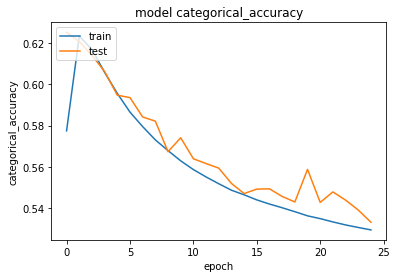

In [30]:
# summarize history for categorical_accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

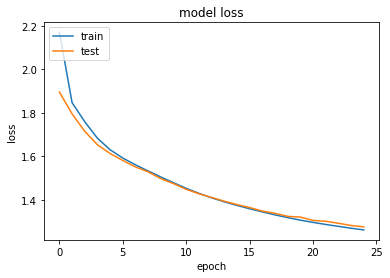

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save("data/models/ab2-copycat-model")

2022-01-15 17:22:25.734653: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/models/ab2-copycat-model/assets


In [23]:
from pprint import pprint
import random
import numpy as np
import tensorflow as tf

from catanatron.game import Game
from catanatron.models.player import Player, RandomPlayer, Color
from catanatron.players.weighted_random import WeightedRandomPlayer
from catanatron_experimental.play import play_batch
from catanatron_gym.envs.catanatron_env import to_action_space, ACTION_SPACE_SIZE, from_action_space
from catanatron_gym.features import create_sample_vector, create_sample


class MyPlayer(Player):
    def decide(self, game, playable_actions):
        """Should return one of the playable_actions.

        Args:
            game (Game): complete game state. read-only.
            playable_actions (Iterable[Action]): options to choose from
        Return:
            action (Action): Chosen element of playable_actions
        """
        # ===== YOUR CODE HERE =====
        action_ints = [to_action_space(a) for a in playable_actions]
        mask = np.zeros(ACTION_SPACE_SIZE, dtype=np.float)
        mask[action_ints] = 1
        mask[mask == 0] = np.nan

        # Get action probabilities with neural network.
        vector = create_sample_vector(game, self.color)
        record = create_sample(game, self.color)
        keys = [name[2:] for name in INPUT_COLUMNS] # remove the F_ prefix
        vector = [record[x] for x in keys]
        X = [vector]
        result = model.call(tf.convert_to_tensor(X))

        # Multiply mask with output, and take max.
        clipped_probabilities = np.multiply(mask, result[0])
        clipped_probabilities[np.isnan(clipped_probabilities)] = -np.inf
        action_index = np.argmax(clipped_probabilities)
        action = from_action_space(action_index, playable_actions)
        
        # print(result)
        # print("Playing", action)
        
        return action
        # ===== END YOUR CODE =====

# Play a simple 4v4 game. Edit MyPlayer with your logic!
players = [
    MyPlayer(Color.RED),
    RandomPlayer(Color.WHITE),
]
wins, results_by_player, games = play_batch(5, players)

pprint(wins)
pprint(results_by_player)

# Results: [64, 32, 32] with LR 1e-4 made a bot that won 60% of games against Random. Had %60 categorical accuracy.

2022-01-16 08:40:12,204 DEBUG Playing game 1 / 5. Seating: [MyPlayer:RED, RandomPlayer:WHITE]
2022-01-16 08:40:14,039 DEBUG {'MyPlayer:RED': 2, 'RandomPlayer:WHITE': 10} (1.83 secs) [Color.WHITE:829(2046)]
2022-01-16 08:40:14,041 DEBUG Playing game 2 / 5. Seating: [RandomPlayer:WHITE, MyPlayer:RED]
2022-01-16 08:40:14,801 DEBUG {'MyPlayer:RED': 7, 'RandomPlayer:WHITE': 10} (0.759 secs) [Color.WHITE:346(919)]
2022-01-16 08:40:14,803 DEBUG Playing game 3 / 5. Seating: [RandomPlayer:WHITE, MyPlayer:RED]
2022-01-16 08:40:16,181 DEBUG {'MyPlayer:RED': 10, 'RandomPlayer:WHITE': 7} (1.38 secs) [Color.RED:523(1583)]
2022-01-16 08:40:16,184 DEBUG Playing game 4 / 5. Seating: [RandomPlayer:WHITE, MyPlayer:RED]
2022-01-16 08:40:17,218 DEBUG {'MyPlayer:RED': 4, 'RandomPlayer:WHITE': 10} (1.03 secs) [Color.WHITE:430(1153)]
2022-01-16 08:40:17,220 DEBUG Playing game 5 / 5. Seating: [RandomPlayer:WHITE, MyPlayer:RED]
2022-01-16 08:40:18,102 DEBUG {'MyPlayer:RED': 5, 'RandomPlayer:WHITE': 11} (0.881 s

{<Color.WHITE: 'WHITE'>: 4, <Color.RED: 'RED'>: 1}
{<Color.WHITE: 'WHITE'>: [10, 10, 7, 10, 11],
 <Color.RED: 'RED'>: [2, 7, 10, 4, 5]}
